# 데이터 획득 및 설정

In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import graphviz
import os
from sklearn import tree, ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from sklearn.feature_selection import chi2, SelectKBest, f_classif, mutual_info_classif, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold

from mclLib.server_info import *
from mclLib.featurenames import *
from mclLib.scaler import *

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/' # windows에서 graphviz를 사용하기 위해 변수경로 설정 

c:\Users\MJ\anaconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
engine = create_engine(mysql_server_uri)
conn = engine.connect()

In [4]:
br_full_data = pd.read_sql_table('buyreports', conn)

# Filtering

In [5]:
# Filtering
get_filter = ( br_full_data['isAllBuyed'] == 1) & ( br_full_data['isAllSelled'] == 1)
br = br_full_data[get_filter]

In [6]:

feature_names = f_name_102

feature_size = len(feature_names)
feat_name = np.array(feature_names)
features = feature_names

In [7]:
X = br[features].to_numpy(dtype=np.float64)

In [8]:
y_condition = (br['fMaxPowerAfterBuyWhile10'] >= 0.025)
y = np.where(y_condition, 1, 0)


In [10]:
y.dtype

dtype('int32')

In [11]:


scale_method = ROBUST
# 테스트 상 스케일 방법 중 Normalizer는 좋지 않다.
modelTester = ModelTester(engine, conn)
modelTester.setNpData(X)
modelTester.setScaler(scale_method)
modelTester.fitScale()
X_scaled = modelTester.np_data

In [12]:
X = X.astype(np.float32)

# VarianceThreshold

In [13]:
selector = VarianceThreshold(threshold=1)
train_thresh = selector.fit(X_scaled)
features_out = train_thresh.get_feature_names_out(features)

print(features_out.shape)
print(features_out)

(70,)
['fStartGap' 'fPlusCnt07' 'fMinusCnt07' 'fPlusCnt09' 'fMinusCnt09'
 'fOnlyDownPowerJar' 'nChegyulCnt' 'nHogaCnt' 'nMissCnt'
 'lTotalTradeVolume' 'lTotalBuyVolume' 'lTotalSellVolume'
 'nAccumUpDownCount' 'fAccumUpPower' 'fAccumDownPower' 'lTotalTradePrice'
 'lTotalBuyPrice' 'lTotalSellPrice' 'lMarketCap' 'nAccumCountRanking'
 'nPowerRanking' 'nTotalTradePriceRanking' 'nTotalTradeVolumeRanking'
 'nTotalRank' 'nMinuteTotalRank' 'nMinuteTradePriceRanking'
 'nMinuteTradeVolumeRanking' 'nMinuteBuyPriceRanking'
 'nMinuteBuyVolumeRanking' 'nMinuteCountRanking' 'nMinuteUpDownRanking'
 'nFakeBuyCnt' 'nFakeAssistantCnt' 'nFakeResistCnt' 'nPriceUpCnt'
 'nPriceDownCnt' 'nTotalFakeCnt' 'nUpCandleCnt' 'nDownCandleCnt'
 'nUpTailCnt' 'nDownTailCnt' 'nCandleTwoOverRealCnt' 'fSpeedCur'
 'fTradeCur' 'fPureTradeCur' 'fPureBuyCur' 'fSharePerHoga'
 'fSharePerTrade' 'fHogaPerTrade' 'fMaDownFsVal' 'fMa20mVal' 'fMa1hVal'
 'fMa2hVal' 'fMaxMaDownFsVal' 'fMaxMa20mVal' 'fMaxMa1hVal' 'fMaxMa2hVal'
 'nMaxMaDown

# SelectKBest

In [14]:
# 분석방법 
#For classification: chi2, f_classif, mutual_info_classif

In [15]:
selector = SelectKBest(score_func=f_classif, k=20)

In [16]:
X_selected = selector.fit_transform(X, y)

In [17]:

## selector.get_support()
selected_mask = selector.get_support()
## 선택된 특성(변수)들
selected_names = feat_name[selected_mask]
## 선택되지 않은 특성(변수)들
unselected_names = feat_name[~selected_mask]
print('Selected names: ', selected_names, end='\n\n')
print('Unselected names: ', unselected_names)

Selected names:  ['fStartGap' 'fPowerWithOutGap' 'fPower' 'fPlusCnt07' 'fMinusCnt07'
 'fPlusCnt09' 'fMinusCnt09' 'fPowerJar' 'fOnlyUpPowerJar'
 'nTotalTradeVolumeRanking' 'nFakeResistCnt' 'nShootingCnt'
 'nCandleTwoOverRealCnt' 'nCandleTwoOverRealNoLeafCnt' 'fSpeedCur'
 'fHogaSpeedCur' 'fTradeCur' 'fPureBuyCur' 'fISlope' 'fRSlope']

Unselected names:  ['nBuyStrategyIdx' 'nRqTime' 'fOnlyDownPowerJar' 'nTradeCnt' 'nChegyulCnt'
 'nHogaCnt' 'nNoMoveCnt' 'nFewSpeedCnt' 'nMissCnt' 'lTotalTradeVolume'
 'lTotalBuyVolume' 'lTotalSellVolume' 'nAccumUpDownCount' 'fAccumUpPower'
 'fAccumDownPower' 'lTotalTradePrice' 'lTotalBuyPrice' 'lTotalSellPrice'
 'lMarketCap' 'nAccumCountRanking' 'nMarketCapRanking' 'nPowerRanking'
 'nTotalBuyPriceRanking' 'nTotalBuyVolumeRanking'
 'nTotalTradePriceRanking' 'nTotalRank' 'nMinuteTotalRank'
 'nMinuteTradePriceRanking' 'nMinuteTradeVolumeRanking'
 'nMinuteBuyPriceRanking' 'nMinuteBuyVolumeRanking' 'nMinutePowerRanking'
 'nMinuteCountRanking' 'nMinuteUpDownRankin

# SelectFromModel

In [18]:
# will select those features which importance is greater than the mean importance of all the features by default
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X, y)

selected_feat = feat_name[selector.get_support()]
selected_feat

array(['fStartGap', 'fPowerWithOutGap', 'fPower', 'fPlusCnt07',
       'fMinusCnt07', 'fPlusCnt09', 'fMinusCnt09', 'fPowerJar',
       'fOnlyUpPowerJar', 'nTotalTradeVolumeRanking', 'nFakeResistCnt',
       'nShootingCnt', 'nCandleTwoOverRealCnt',
       'nCandleTwoOverRealNoLeafCnt', 'fSpeedCur', 'fHogaSpeedCur',
       'fTradeCur', 'fPureBuyCur', 'fISlope', 'fRSlope'], dtype='<U27')

# Decision Tree - Classifer

In [9]:
clf = tree.DecisionTreeClassifier(max_depth=10)
#clf = tree.ExtraTreeClassifier(max_depth= 5)
clf = clf.fit(X, y)

In [10]:
dot_data = tree.export_graphviz(clf,   # 의사결정나무 모형 대입
                               out_file = None,  # file로 변환할 것인가
                               feature_names = features,  # feature 이름
                               class_names = np.array(['fail', 'suc']),  # target 이름
                               filled = True,           # 그림에 색상을 넣을것인가
                               rounded = True,          # 반올림을 진행할 것인가
                               special_characters = True)   # 특수문자를 사용하나

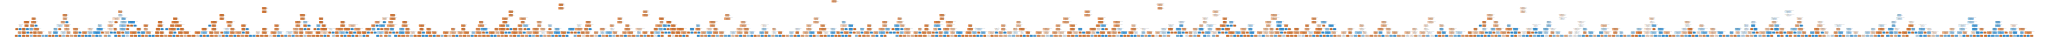

In [11]:
graph = graphviz.Source(dot_data)
graph

# Random Forest

#### Random Forest Built-in Feature Importance

In [22]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf.fit(X, y)

RandomForestClassifier(max_depth=5)

In [ ]:
rf.feature_importances_ # 피처들의 중요도

In [ ]:
# plt.figure(figsize=(20, 20))
# plt.barh(feat_name, rf.feature_importances_)

Text(0.5, 0, 'Random Forest Feature Importance')

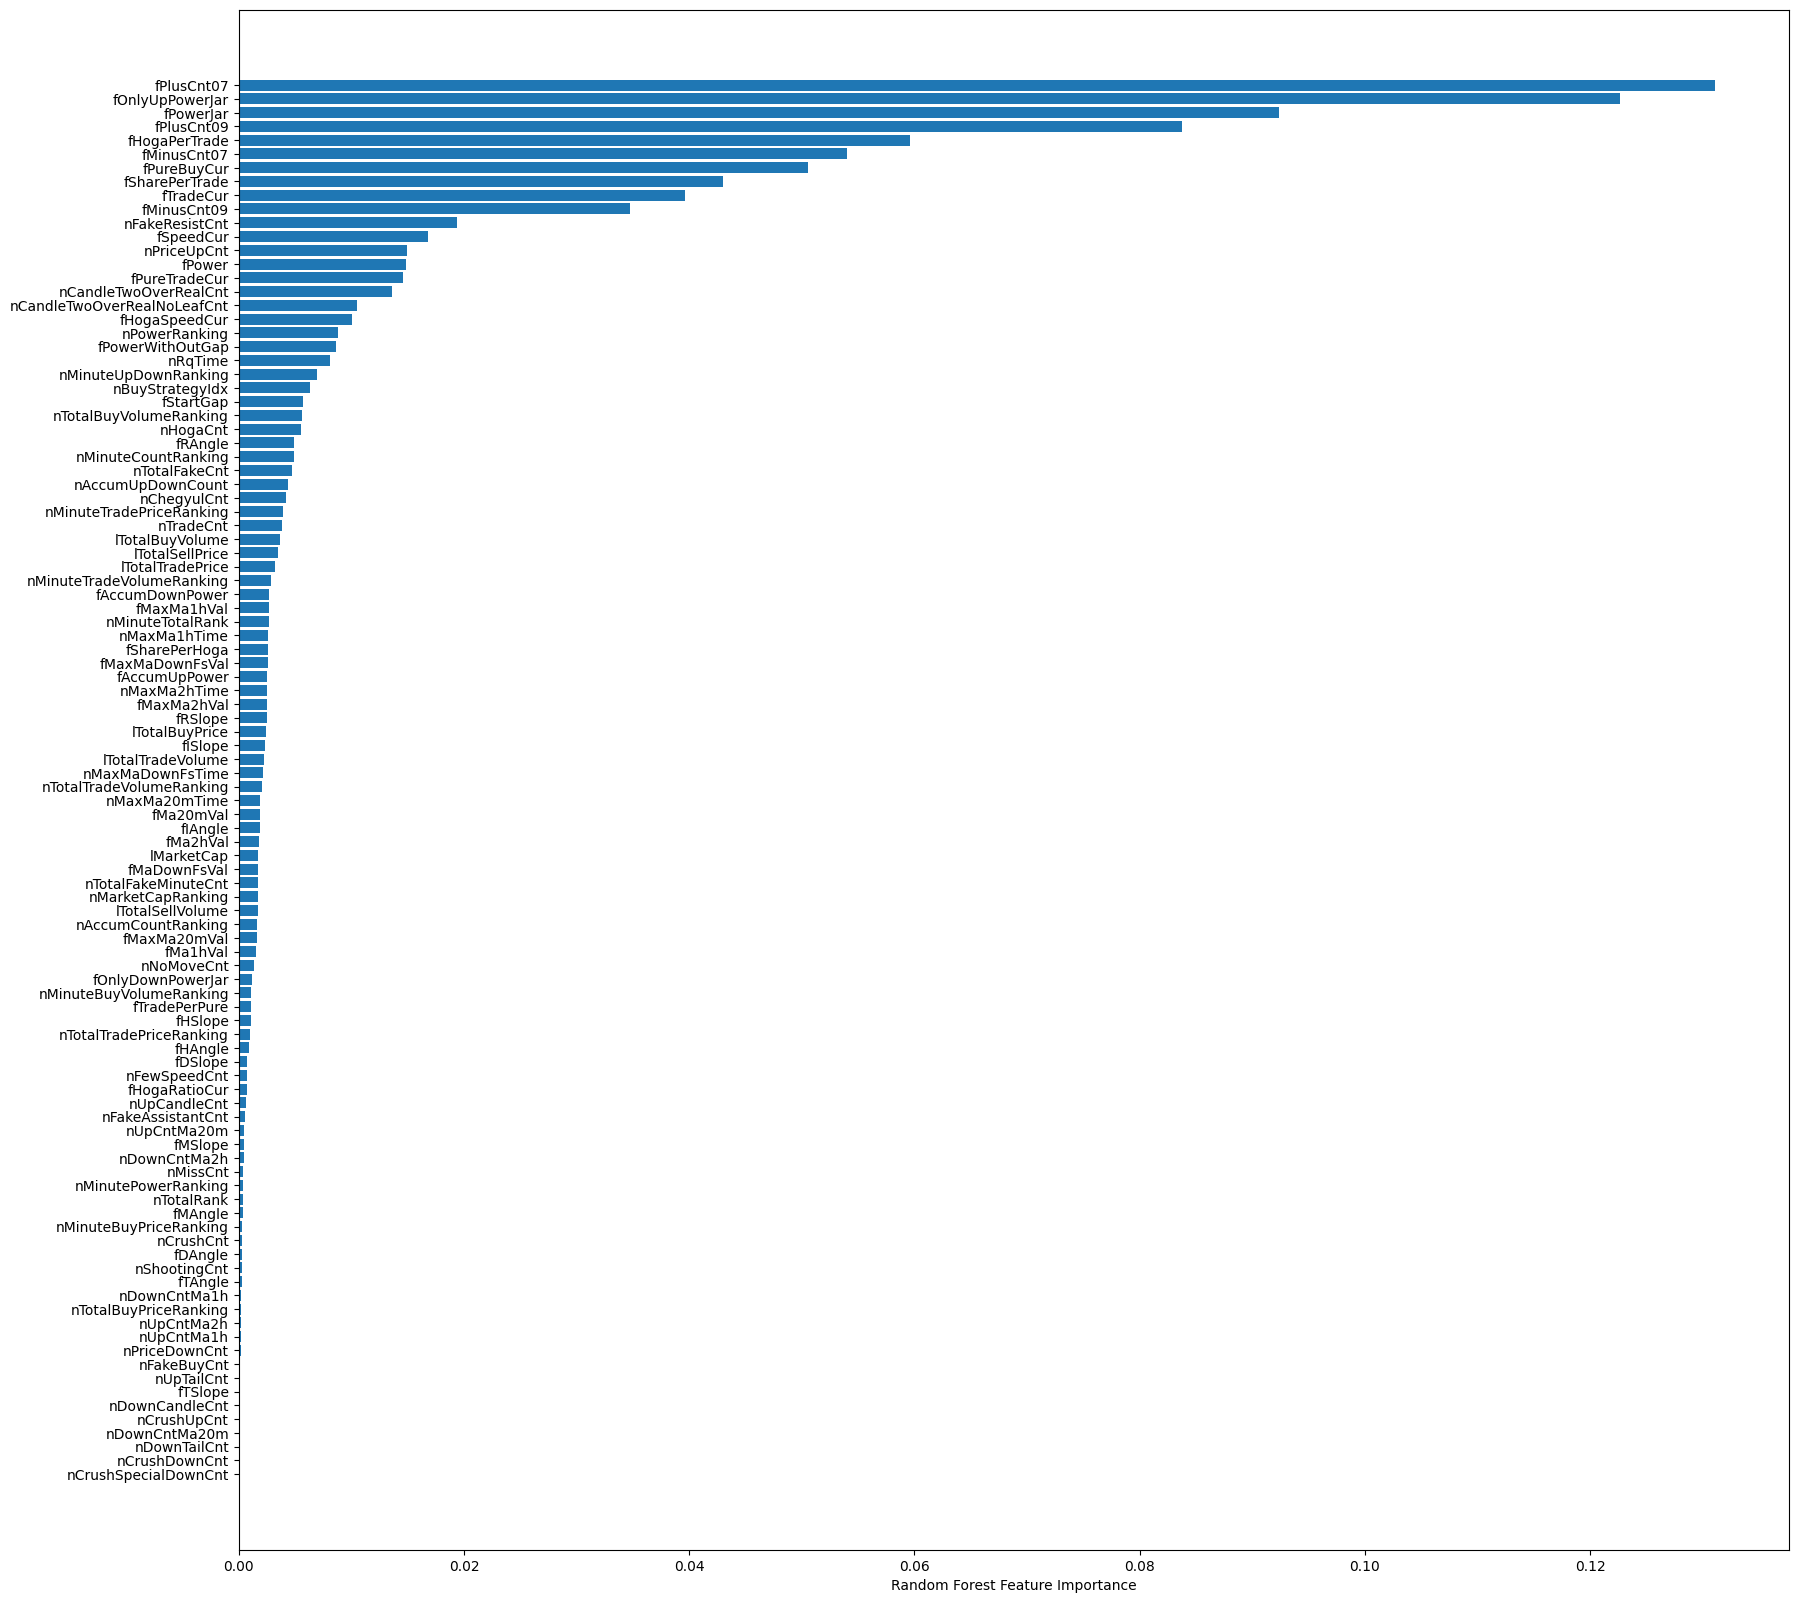

In [23]:
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize=(20, 20))
plt.barh(feat_name[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

#### Permutation Based Feature Importance (with scikit-learn)

In [24]:
perm_importance = permutation_importance(rf, X, y)

Text(0.5, 0, 'Permutation Importance')

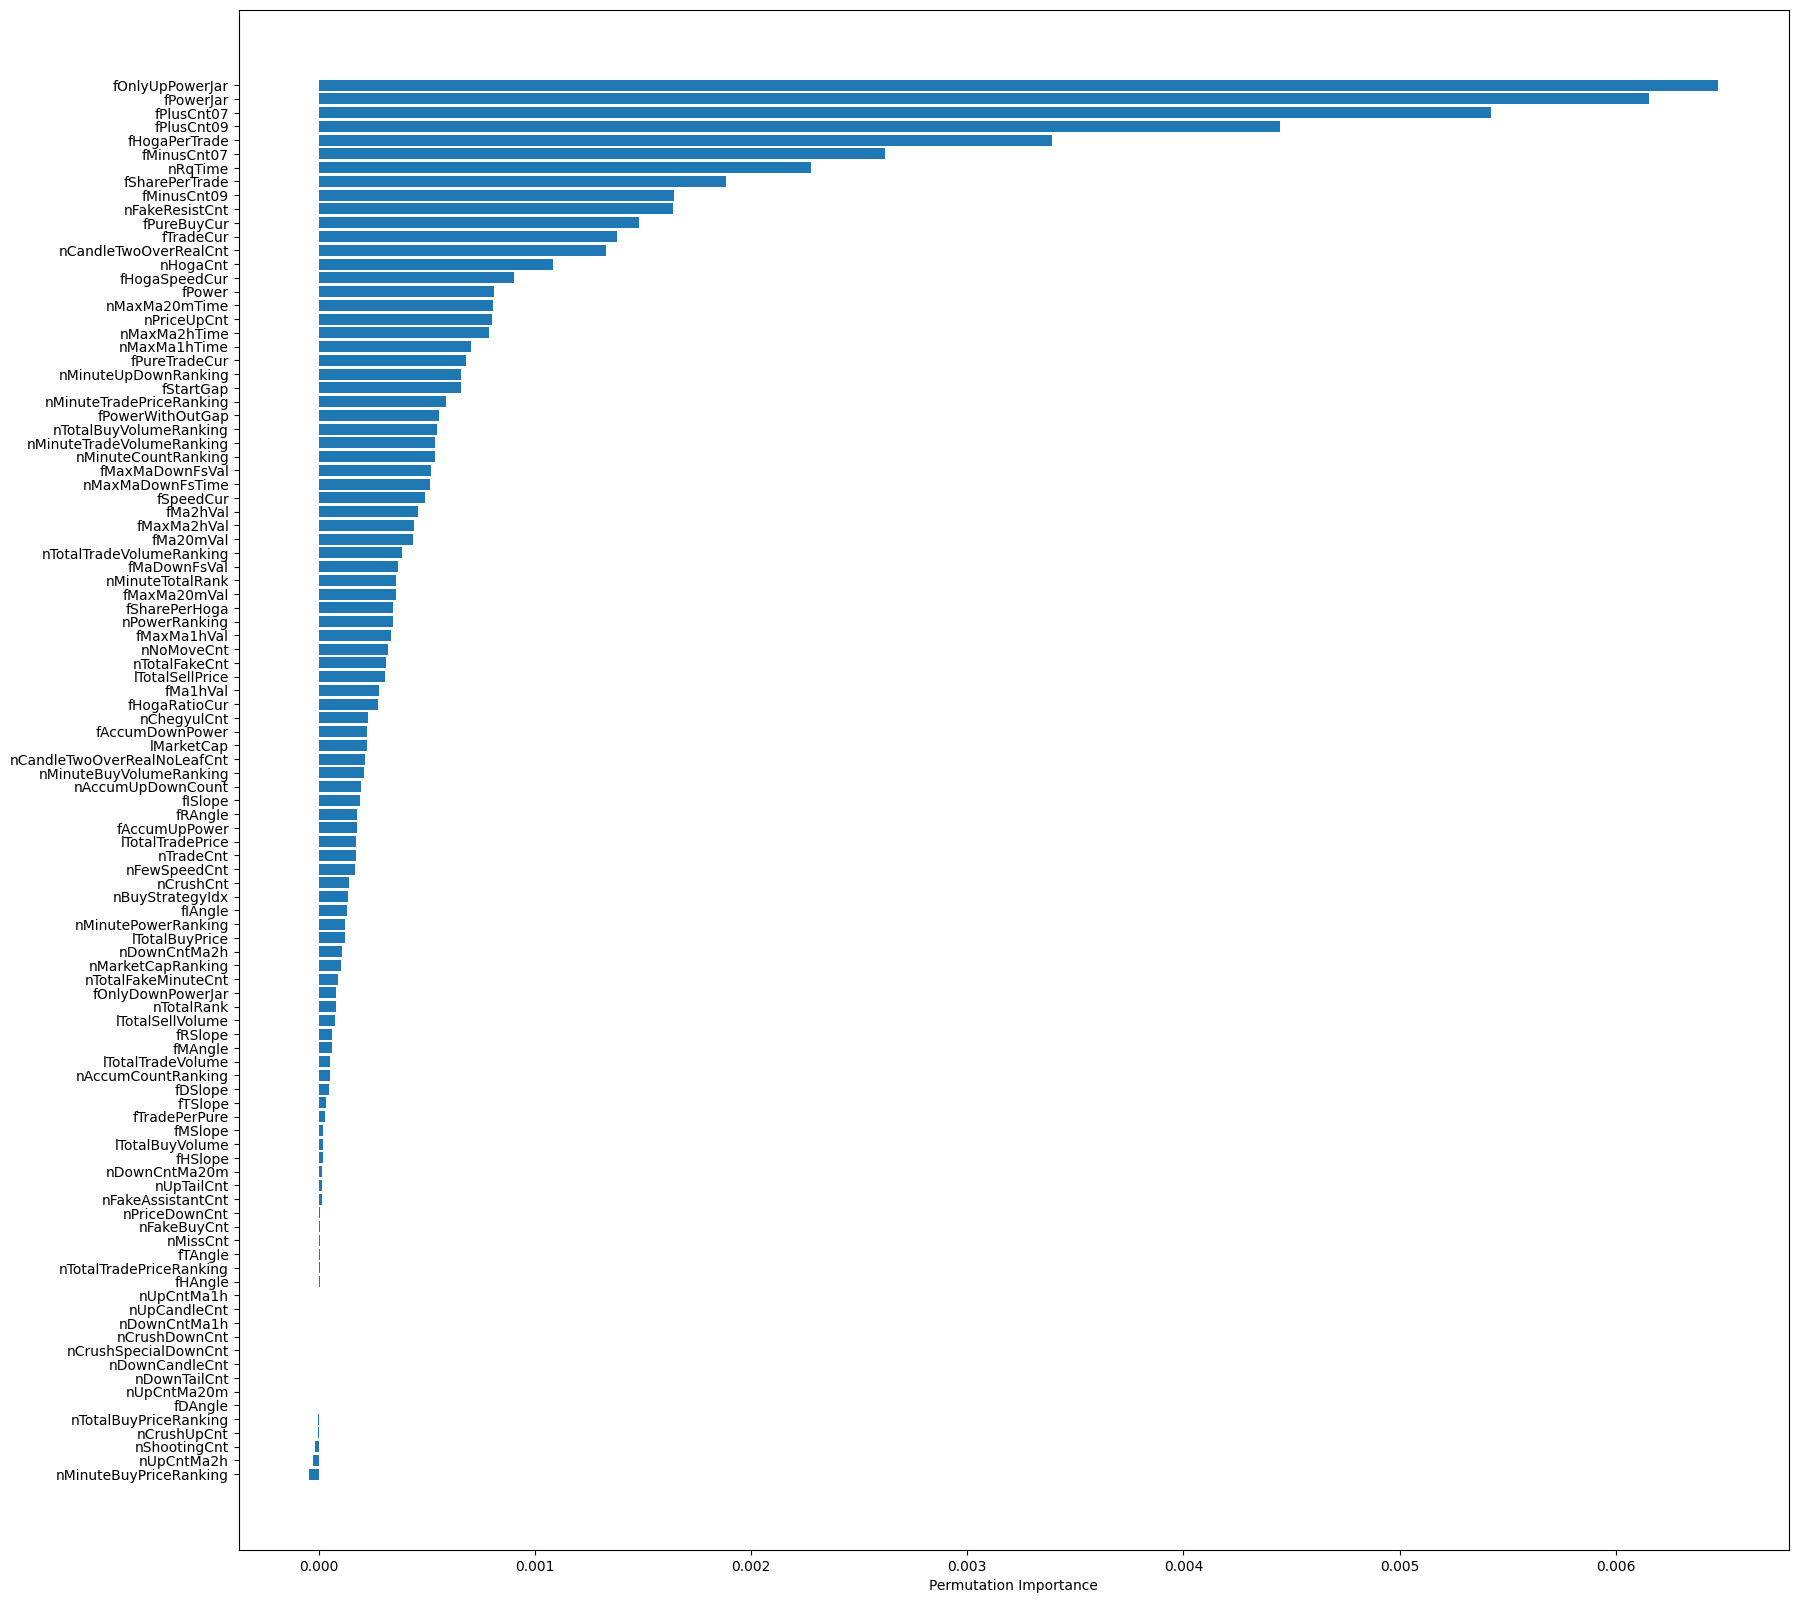

In [25]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(20, 20))
plt.barh(feat_name[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

#### Feature Importance Computed with SHAP Values

Shap plot에 대해서  
Ref : https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a  
Ref( Kernel Shap vs Tree Shap ) : https://towardsdatascience.com/kernelshap-vs-treeshap-e00f3b3a27db
1. 요약플롯 summary_plot()
2. 종속성플롯 : dependency_plot()
3. 개별힘플롯 : force_plot(각각)
4. 집합력플롯 : force_plot()

In [ ]:
# shaKernelExplainer은 feature갯수에 따라 시간이 지수적으로 올라감
rf2 = RandomForestClassifier(n_estimators=100)
rf2.fit(X, y)
explainer = shap.TreeExplainer(rf2) #트리가 아니고 선형회귀기반 중요도분석 KernelExplainer 단점 : 시간이 오래걸림, TreeExplainer도 오래걸림
shap_values = explainer.shap_values(X) # X_test에 관한 각각의 중요도 변수들?? 

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar", feature_names=feat_name) # plot_type  : 다양하게

In [ ]:
shap.summary_plot(shap_values, X, feature_names=feat_name)

In [ ]:
specific_var = "fPlusCnt07"
shap.dependence_plot(specific_var, shap_values, X, feature_names=feat_name)

In [ ]:
shap.initjs() # javascript 초기화 (graph 초기화)
specific_start_row = 2
specific_end_row = 3000

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[specific_start_row,:], X[specific_start_row,:],feature_names=feat_name)  

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[specific_start_row:,:], X[specific_start_row::,:], feature_names=feat_name)  